In [4]:
from principal_DBN_alpha import *
from principal_RBM_alpha import *
from scipy.special import softmax
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import time
import pickle
import logging

In [2]:
class DNN():
    def __init__(self, config) -> None:
        self.config = config
        self.dbn = init_DBN(config[:-1])
        self.classification_layer = init_RBM(config[-2], config[-1])

In [3]:
def init_DNN(config):
    """Initiate the parameters in DNN

    Parameters
    ----------
    config : list of integers
        number of neurones in each layer

    Returns
    -------
    instance of DNN class
    """
    assert len(config) > 2, "Must provide more than 2 integer arguments!"
    assert all(isinstance(x, int) for x in config), "All inputs must be integer!"
    return DNN(config)

In [4]:
def pretain_DNN(data, dnn, epochs, lr, batch_size):
    """Greedy layer-wise pretraining for DBN in the DNN

    Parameters
    ----------
    data : numpy.ndarray: (n_samples, n_neurones_visible)
        training data
    dnn : instance of DNN class
        a DNN structure
    epochs : int
        number of epochs
    lr : float
        learning rate
    batch_size : int
        number of samples in one batch

    Returns
    -------
    a trained DNN instance
    """
    dnn.dbn = train_DBN(data, dnn.dbn, epochs, lr, batch_size)
    return dnn

In [5]:
def calcul_softmax(data, rbm):
    """Compute softmax for output of RBM

    Parameters
    ----------
    data : numpy.ndarray: (n_samples, n_neurones_visible)
        input data
    rbm : instance of RBM class

    Returns
    -------
    numpy.ndarray: (n_samples, n_neurones_hidden)
    """
    x = data @ rbm.w + rbm.b
    return softmax(x, axis=1)

In [6]:
def entree_sortie_reseau(data, dnn):
    """Compute output of each layer in DNN

    Parameters
    ----------
    data : numpy.ndarray: (n_samples, n_neurones_visible)
        input data
    dnn : instance of DNN class

    Returns
    -------
    list
        list of outputs in each layer
    """
    list_output = []
    for layer in dnn.dbn.layers:
        h_proba = entree_sortie_RBM(data, layer)
        data = np.random.binomial(1, h_proba, size=h_proba.shape)
        list_output.append(data)
    list_output.append(calcul_softmax(data, dnn.classification_layer))
    return list_output

In [7]:
def get_data_matrix_from_dataset(dataset):
    """Convert the Dataset (in Pytorch) to the numpy form

    Parameters
    ----------
    dataset : instance of Dataset class

    Returns
    -------
    data_matrix: numpy.ndarray
        Feature matrix of input data
    labels: numpy.ndarray
        Corresponding targets 
    """
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=256, 
                                            shuffle=False)
    data_matrix = []
    labels = []
    for data, label in data_loader:
        data_matrix.append(data)
        labels.append(label)
        
    data_matrix = torch.cat(data_matrix, dim=0)
    data_matrix = data_matrix.numpy().reshape(-1, 28*28)
    labels = torch.cat(labels, dim=0).numpy()
    return data_matrix, labels

## Load data MNIST

In [7]:
class BinarizedMNIST(Dataset):
    def __init__(self, dataset_mnist):
        super(BinarizedMNIST, self).__init__()
        self.data = dataset_mnist.data
        self.targets = dataset_mnist.targets

    def __getitem__(self, index):
        
        img = self.data[index]
        target = self.targets[index]
        img[img < 0.5] = 0
        img[img >= 0.5] = 1
        return img.float(), target

    def __len__(self):
        return len(self.targets)

In [11]:
def get_model(config):
    """Define a model in Pytorch 

    Parameters
    ----------
    config : list of integers
        Number of neurones in each layer

    Returns
    -------
    model in Pytorch
    """
    layers = []
    for i in range(len(config)-2):
        layer = nn.Linear(config[i], config[i])
        activation = nn.Sigmoid()
        layers.append(layer)
        layers.append(activation)
    layers.append(nn.Linear(config[-2], config[-1]))
    model = nn.Sequential(*layers)
    return model

In [12]:
def evaluate(model, data_loader):
    """Evaluate the model on dataset

    Parameters
    ----------
    model : a trained model in Pytorch
    data_loader : DataLoader instance in Pytorch

    Returns
    -------
    Float
        Cross Entropy loss
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    loss_total = 0
    for input, label in data_loader:
        input = input.reshape(-1, 28*28)
        output = model(input)
        loss_total += criterion(output, label) * input.shape[0]
    loss_total /= len(data_loader.dataset)
    return loss_total

In [13]:
def set_params_from_dnn_to_torchModel(dnn, model):
    """Set parameters of DNN to a model in Pytorch

    Parameters
    ----------
    dnn : instance of DNN class
    model : a model in Pytorch
    """
    with torch.no_grad():
        for i in range(dnn.dbn.n_layers):
            new_w = np.swapaxes(dnn.dbn.layers[i].w, 0, 1)
            model[2*i].weight = nn.Parameter(torch.from_numpy(new_w).float())
            model[2*i].bias = nn.Parameter(torch.from_numpy(dnn.dbn.layers[i].b).float())
        new_w = np.swapaxes(dnn.classification_layer.w, 0, 1)
        model[-1].weight = nn.Parameter(torch.from_numpy(new_w).float())
        model[-1].bias = nn.Parameter(torch.from_numpy(dnn.classification_layer.b).float())


In [14]:
def set_params_from_torchModel_to_dnn(dnn, model):
    """Set parameters of a model in Pytorch to DNN

    Parameters
    ----------
    dnn : instance of DNN class
    model : a model in Pytorch
    """
    with torch.no_grad():
        for i in range(dnn.dbn.n_layers):
            dnn.dbn.layers[i].w = np.swapaxes(model[2*i].weight.numpy(), 0, 1)
            dnn.dbn.layers[i].b = model[2*i].bias.numpy()
        dnn.classification_layer.w = np.swapaxes(model[-1].weight.numpy(), 0, 1)
        dnn.classification_layer.b = model[-1].bias.numpy()

In [15]:
def train_DNN(dataset, dnn, epochs, lr, batch_size, pre_training=True):
    """Train a Pytorch model, then convert it to a DNN instance

    Parameters
    ----------
    dataset : Dataset instance
        Training data
    dnn : instance of DNN class
    epochs : int
        number of epochs
    lr : float
        learning rate
    batch_size : int
        number of samples in one batch
    pre_training : bool, optional
        whether to load the parameters of dnn to Pytorch model, by default True

    Returns
    -------
    dnn : a trained DNN
    """
    model = get_model(dnn.config)
    model = model.float()
    if pre_training:
        set_params_from_dnn_to_torchModel(dnn, model)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size, 
                                            shuffle=True)

    for epoch in range(1, epochs+1):
        model.train()
        for input, label in data_loader:
            input = input.reshape(-1, 28*28)
            optimizer.zero_grad()
            output = model.forward(input)
            loss = criterion(output, label)
            loss.backward() 
            optimizer.step()
        loss_total = evaluate(model, data_loader)
        print(f"Epoch: {epoch:>3d} | Evaluation CE loss on training set : {loss_total:.2f}")

    set_params_from_torchModel_to_dnn(dnn, model)
    
    return dnn

In [16]:
def test_DNN(data_matrix, labels, dnn):
    """Evaluate the DNN 

    Parameters
    ----------
    data_matrix: numpy.ndarray
        Feature matrix of input data
    labels: numpy.ndarray
        Corresponding targets 
    dnn : a trained DNN

    Returns
    -------
    Float
        Error rate of classification
    """
    outputs = entree_sortie_reseau(data_matrix, dnn)
    pred = np.argmax(outputs[-1], axis=1)
    err_rate = np.mean(pred != labels)
    return err_rate

In [56]:
logging.config.fileConfig("logging.conf")
logger = logging.getLogger()

In [57]:
def retropropagation(dataset, dataset_test, dnn, epochs, lr, batch_size, pre_training=True, pre_trained_model="3_layer_200"):
    """Training process of DNN

    Parameters
    ----------
    dataset : Dataset instance
        Training data
    dataset_test : Dataset instance
        Test data
    dnn : instance of DNN class
    epochs : int
        number of epochs
    lr : float
        learning rate
    batch_size : int
        number of samples in one batch
    pre_training : bool, optional
        whether to pre-train the DNN in an unsupervised way, by default True
    pre_trained_model : str, optional
        the file name of pre-trained DNN model. Used to load or save model

    Returns
    -------
    dnn : a trained DNN
    """
    logger.info("Loading data matrix from dataset...")
    data_matrix, labels = get_data_matrix_from_dataset(dataset)
    if pre_training:
        filepath = os.path.join("models", pre_trained_model + ".pickle")
        if os.path.isfile(filepath):
            logger.info("Loading pretrained DNN model from " + filepath)
            with open(filepath, 'rb') as handle:
                dnn = pickle.load(handle)
        else:
            logger.info("Start pretraining DNN...")
            start_time = time.time()
            dnn = pretain_DNN(data_matrix, dnn, 100, lr, batch_size)
            logger.info(f"Pretraining finished! Consumed time: {(time.time()- start_time):.2f}s")
            with open(filepath, 'wb') as handle:
                pickle.dump(dnn, handle, protocol=pickle.HIGHEST_PROTOCOL)

    logger.info("Start fine-tuning DNN...")
    start_time = time.time()
    dnn = train_DNN(dataset, dnn, epochs, lr, batch_size, pre_training)
    logger.info(f"Fine-tuning finished! Consumed time: {(time.time()- start_time):.2f}s")

    err_rate = test_DNN(data_matrix, labels, dnn)
    data_matrix_test, labels_test = get_data_matrix_from_dataset(dataset_test)
    err_rate_test = test_DNN(data_matrix_test, labels_test, dnn)
    logger.info(f"After fine-tuning: error rate on training set = {err_rate * 100:.1f}% || " 
          f"error rate on test set = {err_rate_test * 100:.1f}%")

    return dnn

In [5]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
dataset_test = torchvision.datasets.MNIST(data_dir, 
                                          train=False, 
                                          download=True, 
                                          transform=transforms.ToTensor())

In [8]:
dataset_binarized = BinarizedMNIST(dataset)
dataset_binarized_test = BinarizedMNIST(dataset_test)

In [38]:
import warnings

warnings.filterwarnings('ignore')

In [58]:
dnn = init_DNN([784, 200, 200, 200, 10])
dnn = retropropagation(dataset_binarized, dataset_binarized_test,
                       dnn, 2, 1e-1, 128, pre_training=True, pre_trained_model="3_layers_200")

2023-02-25 18:39:51|    INFO|2714304349.py[:26]|Loading data matrix from dataset...
2023-02-25 18:39:53|    INFO|2714304349.py[:31]|Loading pretrained DNN model from models\3_layers_200.pickle
2023-02-25 18:39:53|    INFO|2714304349.py[:42]|Start fine-tuning DNN...
Epoch:   1 | Evaluation CE loss on training set : 0.33
Epoch:   2 | Evaluation CE loss on training set : 0.27
2023-02-25 18:40:12|    INFO|2714304349.py[:45]|Fine-tuning finished! Consumed time: 18.80s
2023-02-25 18:40:16|    INFO|2714304349.py[:50]|After fine-tuning: error rate on training set = 10.0% || error rate on test set = 9.5%


In [59]:
logger.handlers

[<TimedRotatingFileHandler d:\VScode\RBM_DBN\logs\DNNlog.log (DEBUG)>,
 <StreamHandler stdout (DEBUG)>]

In [60]:
for hdle in logger.handlers[:]:
    if isinstance(hdle,logging.FileHandler): 
        hdle.close()
        logger.removeHandler(hdle)

In [61]:
os.path.exists("models")

True

In [62]:
os.makedirs("test A/B")

In [1]:
os.path.exists(os.path.join("output/DBN", "DBN_layers_2_nodes_100_character(s)_1.png"))

NameError: name 'os' is not defined

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from principal_RBM_alpha import *
lire_alpha_digit()

Loading data...
Finished!


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [9]:
import random

indice = random.sample(range(len(dataset_binarized)), 1000)

In [10]:
trainset_1000 = torch.utils.data.Subset(dataset_binarized, indice)

In [1]:
import matplotlib.pyplot as plt

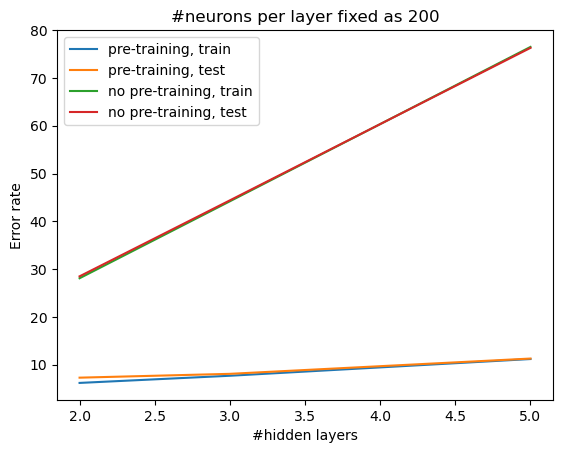

In [4]:
x = [2, 3, 5]
y1 = [6.2, 7.7, 11.2]
y2 = [7.3, 8.1, 11.3]
y3 = [28.1, 44.2, 76.5]
y4 = [28.5, 44.4, 76.3]

plt.plot(x, y1, label='pre-training, train')
plt.plot(x, y2, label='pre-training, test')
plt.plot(x, y3, label='no pre-training, train')
plt.plot(x, y4, label='no pre-training, test')
plt.xlabel("#hidden layers")
plt.ylabel("Error rate")
plt.title("#neurons per layer fixed as 200", fontsize=12)
plt.legend()
plt.show()

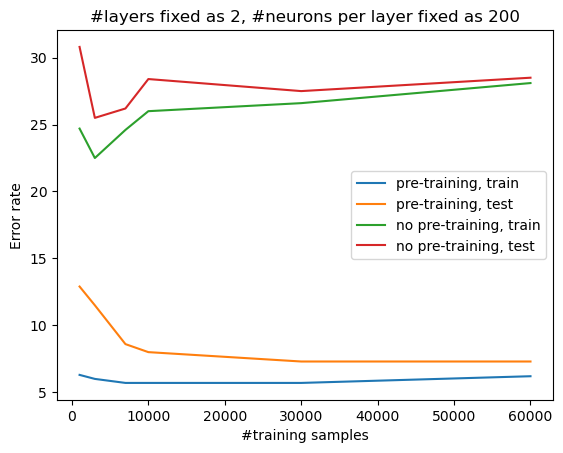

In [7]:
x = [1000, 3000, 7000, 10000, 30000, 60000]
y1 = [6.3, 6.0, 5.7, 5.7, 5.7, 6.2]
y2 = [12.9, 11.5, 8.6, 8.0, 7.3, 7.3]
y3 = [24.7, 22.5, 24.6, 26.0, 26.6, 28.1]
y4 = [30.8, 25.5, 26.2, 28.4, 27.5, 28.5]

plt.plot(x, y1, label='pre-training, train')
plt.plot(x, y2, label='pre-training, test')
plt.plot(x, y3, label='no pre-training, train')
plt.plot(x, y4, label='no pre-training, test')
plt.xlabel("#training samples")
plt.ylabel("Error rate")
plt.title("#layers fixed as 2, #neurons per layer fixed as 200", fontsize=12)
plt.legend()
plt.show()

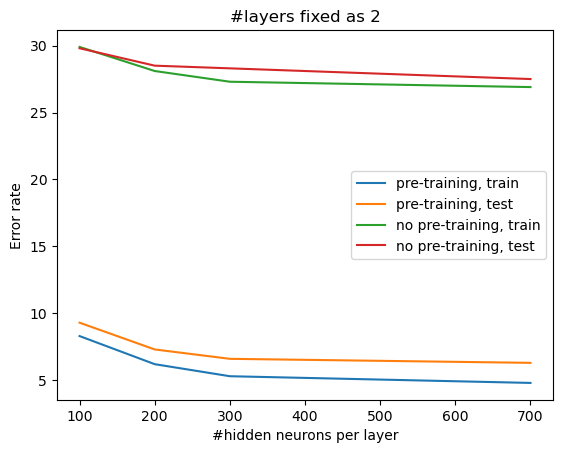

In [8]:
x = [100, 200, 300, 700]
y1 = [8.3, 6.2, 5.3, 4.8]
y2 = [9.3, 7.3, 6.6, 6.3]
y3 = [29.9, 28.1, 27.3, 26.9]
y4 = [29.8, 28.5, 28.3, 27.5]

plt.plot(x, y1, label='pre-training, train')
plt.plot(x, y2, label='pre-training, test')
plt.plot(x, y3, label='no pre-training, train')
plt.plot(x, y4, label='no pre-training, test')
plt.xlabel("#hidden neurons per layer")
plt.ylabel("Error rate")
plt.title("#layers fixed as 2", fontsize=12)
plt.legend()
plt.show()